In [1]:
#/kaggle/input/petfinder-pawpularity-score/sample_submission.csv
#/kaggle/input/petfinder-pawpularity-score/train.csv
#/kaggle/input/petfinder-pawpularity-score/test.csv
#/kaggle/input/petfinder-pawpularity-score/test/c978013571258ed6d4637f6e8cc9d6a3.jpg

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd 
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
from PIL import Image
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
meta = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/train.csv')
meta.head(5)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [4]:
def append_ext(fn):
    return fn+".jpg"

In [5]:
labels = meta[['Id','Pawpularity']]
train_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
labels["Id"] = labels["Id"].apply(append_ext)
labels.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Id,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0.jpg,63
1,0009c66b9439883ba2750fb825e1d7db.jpg,42
2,0013fd999caf9a3efe1352ca1b0d937e.jpg,28
3,0018df346ac9c1d8413cfcc888ca8246.jpg,15
4,001dc955e10590d3ca4673f034feeef2.jpg,72


In [7]:
labels.rename(columns={'Id': 'filename'}, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
labels.head(5)

,filename,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0.jpg,63
1,0009c66b9439883ba2750fb825e1d7db.jpg,42
2,0013fd999caf9a3efe1352ca1b0d937e.jpg,28
3,0018df346ac9c1d8413cfcc888ca8246.jpg,15
4,001dc955e10590d3ca4673f034feeef2.jpg,72


try to get size of the image

In [9]:
im = Image.open('/kaggle/input/petfinder-pawpularity-score/test/c978013571258ed6d4637f6e8cc9d6a3.jpg')
width, height = im.size
print(width, height)

128 128


In [10]:
#for dirname, _, filenames in os.walk('/kaggle/input/petfinder-pawpularity-score/test/'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

Now we know how to get image size we can get sizes of all images. First let's create a dedicated dataset where we can store size with respect of each image id

In [11]:
image_sizes = labels.copy(deep= True)
image_sizes.drop('Pawpularity', axis=1,inplace = True)
image_sizes.head(3)

,filename
0,0007de18844b0dbbb5e1f607da0606e0.jpg
1,0009c66b9439883ba2750fb825e1d7db.jpg
2,0013fd999caf9a3efe1352ca1b0d937e.jpg


Define the function to get images sizes from train dataset

In [12]:
def get_image_sizes(filename):
    path = '/kaggle/input/petfinder-pawpularity-score/train/'
    final_path = path + filename
    im = Image.open(final_path)
    width, height = im.size
    return (width, height)

Apply the function 

In [13]:
image_sizes['width'], image_sizes['height'] = image_sizes.apply(lambda row: get_image_sizes(row['filename']), 
                                                                axis=1,
                                                                result_type='expand').T.values

Check the results and plot distribution of sizes

In [14]:
image_sizes.head(3)

,filename,width,height
0,0007de18844b0dbbb5e1f607da0606e0.jpg,405,720
1,0009c66b9439883ba2750fb825e1d7db.jpg,1032,774
2,0013fd999caf9a3efe1352ca1b0d937e.jpg,720,960


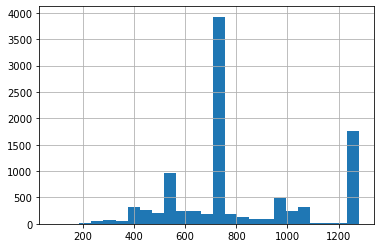

In [15]:
image_sizes['width'].hist(bins=25)
plt.show()

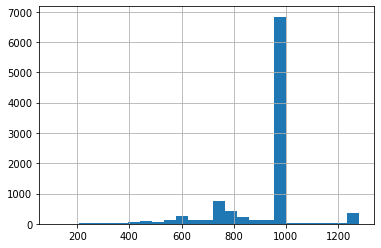

In [16]:
image_sizes['height'].hist(bins=25)
plt.show()

Now we can decide how to rescale our images, we can have two options:
1. use mean of sizes
2. use mode of sizes

After that check which approach gives better model performance in terms of RMSE metric. 
Presumably the mode of sizes should perform better. 

In [17]:
width_mean = image_sizes['width'].mean()
height_mean = image_sizes['height'].mean()
width_mode = image_sizes['width'].mode()
height_mode = image_sizes['height'].mode()

print('mean width: ', width_mean)
print('mean height: ', height_mean)
print('mode width: ', width_mode)
print('mode width: ', height_mode)

mean width:  804.4262510088781
mean height:  904.2843018563358
mode width:  0    720
dtype: int64
mode width:  0    960
dtype: int64


In [18]:
image_sizes.to_csv('image_sizes.csv',index=False)

In [19]:
result = pd.merge(image_sizes, labels, on="filename")
result.head()

,filename,width,height,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0.jpg,405,720,63
1,0009c66b9439883ba2750fb825e1d7db.jpg,1032,774,42
2,0013fd999caf9a3efe1352ca1b0d937e.jpg,720,960,28
3,0018df346ac9c1d8413cfcc888ca8246.jpg,405,720,15
4,001dc955e10590d3ca4673f034feeef2.jpg,540,960,72


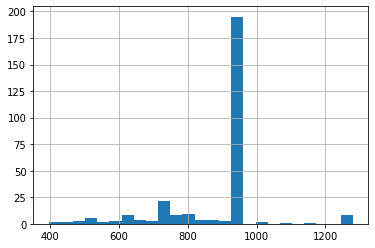

In [20]:
result[result['Pawpularity']==100]['height'].hist(bins=25)
plt.show()

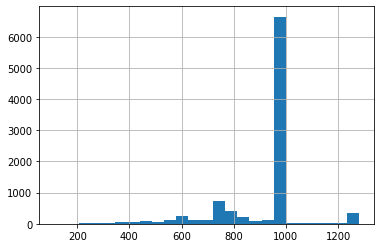

In [21]:
result[result['Pawpularity']<100]['height'].hist(bins=25)
plt.show()

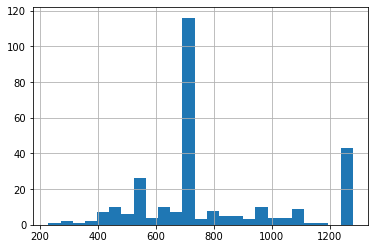

In [22]:
result[result['Pawpularity']==100]['width'].hist(bins=25)
plt.show()

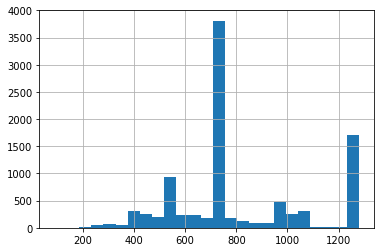

In [23]:
result[result['Pawpularity']<100]['width'].hist(bins=25)
plt.show()

In [24]:
labels['Pawpularity'].mean()

38.03904358353511

In [25]:
dummy_test = labels.copy(deep=True)

In [26]:
dummy_test['dummy_score'] = labels['Pawpularity'].mean()

In [27]:
dummy_test.head()

,filename,Pawpularity,dummy_score
0,0007de18844b0dbbb5e1f607da0606e0.jpg,63,38.039044
1,0009c66b9439883ba2750fb825e1d7db.jpg,42,38.039044
2,0013fd999caf9a3efe1352ca1b0d937e.jpg,28,38.039044
3,0018df346ac9c1d8413cfcc888ca8246.jpg,15,38.039044
4,001dc955e10590d3ca4673f034feeef2.jpg,72,38.039044


In [28]:
from sklearn.metrics import mean_squared_error
y_true = dummy_test['Pawpularity']
y_pred = dummy_test['dummy_score']
mean_squared_error(y_true, y_pred, squared=False)

20.59095133915306